# Gallery for DR7

The purpose of this notebook is to build a nice gallery of object images for DR7.  The theme is the Arp atlas of interacting galaxies.

For future reference: The notebook must be run from https://jupyter-dev.nersc.gov with the following (approximate) activation script:

```bash
#!/bin/bash                                                                                                           
version=$1                                                                                                            
connection_file=$2                                                                                                    

desiconda_version=20180512-1.2.5-img
module use /global/common/software/desi/$NERSC_HOST/desiconda/$desiconda_version/modulefiles
module load desiconda

export LEGACYPIPE_DIR=$SCRATCH/repos/legacypipe                                                                       

export PATH=$LEGACYPIPE_DIR/bin:${PATH}                                                                               
export PYTHONPATH=$LEGACYPIPE_DIR/py:${PYTHONPATH}                                                                    

export PATH=$SCRATCH/repos/build/$NERSC_HOST/bin:$PATH
export PYTHONPATH=$CSCRATCH/repos/build/$NERSC_HOST/lib/python3.6/site-packages:$PYTHONPATH


export DUST_DIR=/global/project/projectdirs/desi/software/${NERSC_HOST}/dust/v0_0

export UNWISE_COADDS_DIR=/global/projecta/projectdirs/cosmo/work/wise/outputs/merge/neo4/fulldepth:/global/project/projectdirs/cosmo/data/unwise/allwise/unwise-coadds/fulldepth
export UNWISE_COADDS_TIMERESOLVED_DIR=/global/projecta/projectdirs/cosmo/work/wise/outputs/merge/neo4

export GAIA_CAT_DIR=/global/project/projectdirs/cosmo/work/gaia/chunks-gaia-dr2-astrom/
export GAIA_CAT_VER=2

export TYCHO2_KD_DIR=/global/project/projectdirs/cosmo/staging/tycho2

export PS1CAT_DIR=/global/project/projectdirs/cosmo/work/ps1/cats/chunks-qz-star-v3 # calibration only

exec python -m ipykernel -f $connection_file
```

### Imports and paths

In [1]:
import os, sys
import shutil, time, warnings
from contextlib import redirect_stdout
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

In [2]:
from astropy.io import ascii
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, vstack, Column
from PIL import Image, ImageDraw, ImageFont

In [3]:
from legacypipe.survey import LegacySurveyData
from legacypipe.runbrick import run_brick
from astrometry.util.util import Tan
from astrometry.util.fits import merge_tables

In [4]:
import multiprocessing
nproc = multiprocessing.cpu_count() // 2

In [5]:
%matplotlib inline

### Preliminaries

Define the data release and the various output directories.

In [6]:
PIXSCALE = 0.262
#PIXSCALE = 2.62

In [7]:
dr = 'dr7'
gallerydir = os.path.join( os.getenv('SCRATCH'), dr)
samplefile = os.path.join(gallerydir, 'sample-{}.fits'.format(dr))

In [8]:
jpgdir = os.path.join(gallerydir, 'jpg')
if not os.path.isdir(jpgdir):
    os.mkdir(jpgdir)

In [9]:
pngdir = os.path.join(gallerydir, 'png')
if not os.path.isdir(pngdir):
    os.mkdir(pngdir)

### Build the sample.

Use the sample of Arp galaxies from NED:
https://ned.ipac.caltech.edu/classic/forms/byrefcode.html
with refcode 1966ApJS...14....1A

In [10]:
names = ('number', 'name', 'ra', 'dec', 'type', 'velocity', 'redshift', 'zflag', 
         'mag', 'separation', 'refs', 'notes', 'nphot', 'pos', 'zref', 'diampoints', 'assoc')
cat = ascii.read(os.path.join(gallerydir, 'arp.txt'), names=names, delimiter='|', 
                 format='basic')
cat = cat[ ['name', 'ra', 'dec', 'type', 'redshift', 'mag'] ]

for gal in ('NGC 3746', 'NGC 3745', 'NGC 3748', 'NGC 3754', 
            'NGC 3753', 'NGC 3750', 'ARP 320', 'NGC 3751',
            'ARP 064', 'NGC 7837', 'NGC 7838', 'NGC 7752',
            'ARP 132E'):
    ww = np.where( cat['name'] == gal )[0]
    if len(ww) > 0:
        cat.remove_rows(ww)

# Replace the NGC3746 galaxies with the center of the group.
cat.add_row( ['NGC 3746 Group', 174.4588, 21.9980, 'GGroup', 0.030094, 15] )

nobj = len(cat)

goodname1 = np.array(['NED' not in nn for nn in ma.getdata(cat['name'])])
goodname2 = np.array(['NOTES' not in nn for nn in ma.getdata(cat['name'])])
goodname = goodname1 * goodname2

tt = ma.getdata(cat['type'])
keep = np.logical_and( (tt != 'HII'), (tt != 'PofG') )
keep = np.logical_and( keep, (tt != 'QSO') )
#keep = np.logical_and( keep, (tt != 'G') )
keep = np.logical_and( keep, goodname)

mag = ma.getdata(cat['mag'])
for filt in ('g', 'V', 'B', '+', 'b', ':', 'E', 'A', 'r', 'R', 'P', 'K'):
    mag = [mm.replace(filt, ' ') for mm in mag]
mag = np.array(mag).astype('f4')
cat['mag'] = mag
#plt.hist(mag)
magkeep = (mag >= 15) * (mag <= 16)
keep = np.logical_and( keep, magkeep)

# Toss out some boring ones
keep = np.logical_and( keep, cat['name'] != 'ARK 045' )
keep = np.logical_and( keep, cat['name'] != 'UGC 08610' )

cat = cat[keep]
nobj = len(cat)

print(np.unique(ma.getdata(cat['type'])))

# Add diameters
cat['diam'] = np.repeat(3.0, nobj).astype('f4')
#cat['diam'][cat['type'] == 'GPair'] = 3
cat['diam'][np.where(cat['name'] == 'UGC 12891')[0]] = 1.5
cat['diam'][np.where(cat['name'] == 'IC 3481A')[0]] = 5.0
cat['diam'][np.where(cat['name'] == 'IC 0803')[0]] = 2
cat['diam'][np.where(cat['name'] == 'UGC 09561')[0]] = 4
cat['diam'][np.where(cat['name'] == 'ARP 251')[0]] = 1.5
cat['diam'][np.where(cat['name'] == 'ARP 088')[0]] = 1.1
cat['diam'][np.where(cat['name'] == 'MRK 0983')[0]] = 1.1
cat['diam'][np.where(cat['name'] == 'NGC 3068')[0]] = 5
cat['diam'][np.where(cat['name'] == 'UGC 07085A')[0]] = 4
cat['diam'][np.where(cat['name'] == 'ARP 139')[0]] = 2
cat['diam'][np.where(cat['name'] == 'ARP 218')[0]] = 2
cat['diam'][np.where(cat['name'] == 'NGC 3746 Group')[0]] = 7

# Adjust the center of NGC5613 to pull in NGC 5614
ww = np.where(cat['name'] == 'NGC 5613')[0]
cat['name'][ww] = 'NGC 5614 Group'
cat['ra'][ww] = 216.0285
cat['dec'][ww] = 34.8731
cat['diam'][ww] = 4
cat['type'][ww] = 'GGroup'

# Adjust the center of IC4526 to pull in NGC 5829
ww = np.where(cat['name'] == 'IC 4526')[0]
cat['name'][ww] = 'NGC 5829 Group'
cat['ra'][ww] = 225.6650
cat['dec'][ww] = 23.3434
cat['diam'][ww] = 3.5
cat['type'][ww] = 'GGroup'

# Adjust the center of NGC5994 to pull in NGC 5996
ww = np.where(cat['name'] == 'NGC 5994')[0]
cat['name'][ww] = 'NGC 5996 Group'
cat['ra'][ww] = 236.7329
cat['dec'][ww] = 17.8811
cat['diam'][ww] = 3.5
cat['type'][ww] = 'GGroup'

#print(cat[np.where(cat['name'] == 'NGC 5994')])
cat

['G' 'GGroup' 'GPair' 'GTrpl']


name,ra,dec,type,redshift,mag,diam
str24,float64,float64,str6,float64,float32,float32
UGC 12891,0.08167,22.99194,GPair,--,15.1,1.5
ARP 051,1.56983,-13.44808,G,--,15.0,3.0
NGC 7829,1.62075,-13.42061,G,0.01907,15.4,3.0
ARP 246,1.71958,8.35111,GPair,--,15.3,3.0
UGC 00212,5.59596,-1.30339,G,0.016238,15.0,3.0
UGC 00224,5.90708,-0.50639,GPair,--,15.4,3.0
IC 0018,7.14567,-11.58669,G,0.020251,15.46,3.0
IC 0019,7.16452,-11.64078,G,0.020671,15.0,3.0
ARP 251,13.45158,-13.85692,GTrpl,--,15.5,1.5


### Restrict to objects that are in the DR7 footprint.

In [11]:
survey = LegacySurveyData()
survey.output_dir = gallerydir

In [12]:
def get_name(cat, nice=False):
    #import pdb ; pdb.set_trace()
    name = np.atleast_1d(cat['name'])
    if nice:
        outname = name
    else:
        outname = np.array([nn.replace(' ', '_').lower() for nn in name])
        
    if len(outname) == 1:
        outname = outname[0]
    return outname

In [13]:
def simple_wcs(obj, diam):
    """Build a simple WCS object for a single object."""
    size = np.rint(diam / PIXSCALE).astype('int') # [pixels]
    wcs = Tan(obj['ra'], obj['dec'], size/2+0.5, size/2+0.5,
                 -PIXSCALE/3600.0, 0.0, 0.0, PIXSCALE/3600.0, 
                 float(size), float(size))
    return wcs

In [14]:
def _build_sample_one(args):
    """Wrapper function for the multiprocessing."""
    return build_sample_one(*args)

In [15]:
def build_sample_one(obj, factor=2, verbose=False):
    """Wrapper function to find overlapping grz CCDs for a given object.
    
    """
    #print('Working on {}...'.format(obj['arp']))
    diam = factor * obj['diam'] * 60.0 # diameter [arcsec]
    wcs = simple_wcs(obj, diam)
    try:
        ccds = survey.ccds_touching_wcs(wcs) # , ccdrad=2*diam/3600)
    except:
        return None
    
    if ccds:
        # Is there 3-band coverage?
        if 'g' in ccds.filter and 'r' in ccds.filter and 'z' in ccds.filter:
            if verbose:
                print('For {} found {} CCDs, RA = {:.5f}, Dec = {:.5f}, Diameter={:.4f} arcmin'.format(
                        obj['name'], len(ccds), obj['ra'], obj['dec'], obj['diam']))
            return obj
    return None

In [16]:
def build_sample(cat, factor=2, use_nproc=nproc):
    """Build the full sample with grz coverage in DR7."""

    sampleargs = list()
    for cc in cat:
        sampleargs.append( (cc, factor, True) ) # the False refers to verbose=False

    if use_nproc > 1:
        p = multiprocessing.Pool(nproc)
        result = p.map(_build_sample_one, sampleargs)
        p.close()
    else:
        result = list()
        for args in sampleargs:
            result.append(_build_sample_one(args))

    # Remove non-matching objects and write out the sample
    outcat = vstack(list(filter(None, result)))
    print('Found {}/{} objects in the DR7 footprint.'.format(len(outcat), len(cat)))
    
    return outcat

In [17]:
samplelogfile = os.path.join(gallerydir, 'build-sample.log')
print('Building the sample.')
print('Logging to {}'.format(samplelogfile))
t0 = time.time()
with open(samplelogfile, 'w') as log:
    with redirect_stdout(log):
        sample = build_sample(cat)
print('Found {}/{} objects in the DR7 footprint.'.format(len(sample), len(cat)))
print('Total time = {:.3f} seconds.'.format(time.time() - t0))

Building the sample.
Logging to /global/cscratch1/sd/ioannis/dr7/build-sample.log
Found 38/89 objects in the DR7 footprint.
Total time = 0.475 seconds.


In [18]:
print('Writing {}'.format(samplefile))
sample.write(samplefile, overwrite=True)

Writing /global/cscratch1/sd/ioannis/dr7/sample-dr7.fits


In [19]:
sample

name,ra,dec,type,redshift,mag,diam
str24,float64,float64,str6,float64,float32,float32
UGC 12891,0.08167,22.99194,GPair,--,15.1,1.5
ARP 246,1.71958,8.35111,GPair,--,15.3,3.0
UGC 00212,5.59596,-1.30339,G,0.016238,15.0,3.0
UGC 00224,5.90708,-0.50639,GPair,--,15.4,3.0
ARP 251,13.45158,-13.85692,GTrpl,--,15.5,1.5
IC 1623B,16.94817,-17.50697,G,0.020304,15.5,3.0
UGC 00827,19.36958,14.70333,GPair,0.037866,15.4,3.0
ARP 088,19.77167,12.47333,GPair,--,16.0,1.1
MRK 0983,19.84406,12.40362,G,0.0479,16.0,1.1


In [20]:
def qa_sample():
    fig, ax = plt.subplots()
    ax.scatter(cat['ra'], cat['dec'], alpha=0.5, s=10, label='Arp Catalog')
    ax.scatter(sample['ra'], sample['dec'], s=20, label='Objects in DR7 Footprint')
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.legend(loc='lower right')

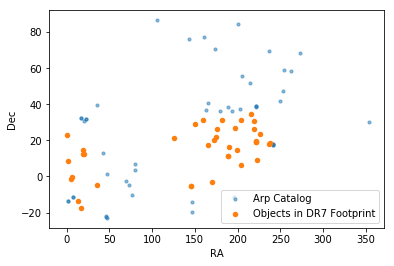

In [21]:
qa_sample()

### Generate the color mosaics for each object.

In [22]:
def custom_brickname(obj, prefix='custom-'): 
    brickname = 'custom-{:06d}{}{:05d}'.format(
        int(1000*obj['ra']), 'm' if obj['dec'] < 0 else 'p', 
        int(1000*np.abs(obj['dec'])))
    return brickname

In [50]:
def custom_coadds_one(obj, scale=PIXSCALE, clobber=False, log=None):
    import subprocess
    #from legacypipe.runbrick import run_brick
    #from astrometry.util.multiproc import multiproc
    #from legacypipe.runbrick import stage_tims, run_brick
    #from legacypipe.coadds import make_coadds

    name = get_name(obj)
    jpgfile = os.path.join(jpgdir, '{}.jpg'.format(name))
    if os.path.isfile(jpgfile) and not clobber:
        print('File {} exists...skipping.'.format(jpgfile))
    else:
        size = np.rint(obj['diam'] * 60 / scale).astype('int') # [pixels]
        #print('Generating mosaic for {} with width={} pixels.'.format(name, size))
        
        bands = ('g', 'r', 'z')
        rgb_kwargs = dict({'Q': 20, 'm': 0.03})
            
        brickname = custom_brickname(obj, prefix='custom-')
        
        cmd = 'python {legacypipe_dir}/py/legacypipe/runbrick.py '
        cmd += '--radec {ra} {dec} --width {width} --height {width} --pixscale {pixscale} '
        cmd += '--threads {threads} --outdir {outdir} --no-write '
        cmd += '--stage image_coadds --force-all --skip-calibs '#' --apodize '
    
        cmd = cmd.format(legacypipe_dir=os.getenv('LEGACYPIPE_DIR'), 
                         ra=obj['ra'], dec=obj['dec'], width=size,
                         pixscale=scale, threads=nproc, outdir=gallerydir)
    
        print(cmd, flush=True, file=log)
        err = subprocess.call(cmd.split(), stdout=log, stderr=log)
        if err != 0:
            print('Something we wrong; please check the logfile for {}.'.format(name))
            return 0
        else:
            #with warnings.catch_warnings():
            #    warnings.simplefilter("ignore")
            #    run_brick(None, survey, radec=(obj['ra'], obj['dec']), pixscale=scale, 
            #              width=size, height=size, rgb_kwargs=rgb_kwargs, threads=nproc, 
            #              stages=['image_coadds'], splinesky=True, early_coadds=True, pixPsf=True, 
            #              hybridPsf=True, normalizePsf=True, write_pickles=False, depth_cut=False, 
            #              apodize=True, do_calibs=False, ceres=False)
            #sys.stdout.flush()    
            
            _jpgfile = os.path.join(survey.output_dir, 'coadd', 'cus', brickname, 
                                   'legacysurvey-{}-image.jpg'.format(brickname))
            shutil.copy(_jpgfile, jpgfile)
            shutil.rmtree(os.path.join(survey.output_dir, 'coadd'))

In [24]:
#custom_coadds_one(sample[0], clobber=True)

In [25]:
def custom_coadds(sample, clobber=False, log=None):
    for obj in sample:
        custom_coadds_one(obj, clobber=clobber, log=log)

In [51]:
coaddslogfile = os.path.join(gallerydir, 'make-coadds.log')
print('Generating the coadds.')
print('Logging to {}'.format(coaddslogfile))
t0 = time.time()
with open(coaddslogfile, 'w') as log:
    #with redirect_stdout(log):
    custom_coadds(sample, clobber=True, log=log)
print('Total time = {:.3f} minutes.'.format((time.time() - t0) / 60))

Generating the coadds.
Logging to /global/cscratch1/sd/ioannis/dr7/make-coadds.log
Total time = 5.649 minutes.


### Add labels and a scale bar.

In [45]:
barlen = np.round(60.0 / PIXSCALE).astype('int')
fonttype = os.path.join(gallerydir, 'Georgia.ttf')

In [46]:
def _add_labels_one(args):
    """Wrapper function for the multiprocessing."""
    return add_labels_one(*args)

In [47]:
def add_labels_one(obj, verbose=False):
    name = get_name(obj)
    nicename = get_name(obj, nice=True)
    
    jpgfile = os.path.join(jpgdir, '{}.jpg'.format(name))
    pngfile = os.path.join(pngdir, '{}.png'.format(name))
    thumbfile = os.path.join(pngdir, 'thumb-{}.png'.format(name))
        
    im = Image.open(jpgfile)
    sz = im.size
    fntsize = np.round(sz[0]/28).astype('int')
    width = np.round(sz[0]/175).astype('int')
    font = ImageFont.truetype(fonttype, size=fntsize)
    draw = ImageDraw.Draw(im)
    # Label the object name--
    draw.text((0+fntsize*2, 0+fntsize*2), nicename, font=font)
    # Add a scale bar--
    x0, x1, yy = sz[1]-fntsize*2-barlen, sz[1]-fntsize*2, sz[0]-fntsize*2
    draw.line((x0, yy, x1, yy), fill='white', width=width)
    im.save(pngfile)    
        
    # Generate a thumbnail
    if True:
        cmd = '/usr/bin/convert -thumbnail 300x300 {} {}'.format(pngfile, thumbfile)
        os.system(cmd)

In [48]:
def add_labels(sample):
    labelargs = list()
    for obj in sample:
        labelargs.append((obj, False))

    #if False:
    if nproc > 1:
        p = multiprocessing.Pool(nproc)
        res = p.map(_add_labels_one, labelargs)
        p.close()
    else:
        for args in labelargs:
            res = _add_labels_one(args)

In [52]:
%time add_labels(sample)

CPU times: user 32.1 ms, sys: 135 ms, total: 167 ms
Wall time: 2.73 s


### Finally, assemble the webpage of good and rejected gallery images.

To test the webpage before release, do

    rsync -auvP /global/cscratch1/sd/ioannis/dr7/png /global/project/projectdirs/cosmo/www/temp/ioannis/dr7/gallery/
    rsync -auvP /global/cscratch1/sd/ioannis/dr7/*.html /global/project/projectdirs/cosmo/www/temp/ioannis/dr7/gallery/



In [32]:
reject = ['arp_246', 'ic_0298', 'ugc_09532', 'ugca_173', 'ugca_174']
toss = np.zeros(len(sample), dtype=bool)
name = get_name(sample)
for ii, nn in enumerate(name):
    for rej in np.atleast_1d(reject):
        toss[ii] = rej in nn.lower()
        if toss[ii]:
            break
print('Rejecting {} objects.'.format(np.sum(toss)))
pngkeep = sample[~toss]
if np.sum(toss) > 0:
    pngrej = sample[toss]
else:
    pngrej = []

Rejecting 4 objects.


In [39]:
htmlfile = os.path.join(gallerydir, 'index.html')
htmlfile_reject = os.path.join(gallerydir, 'index-reject.html')
baseurl = 'http://legacysurvey.org/viewer'

In [53]:
def html_rows(pngkeep, nperrow=4):
    nrow = np.ceil(len(pngkeep) / nperrow).astype('int')
    pngsplit = list()
    for ii in range(nrow):
        i1 = nperrow*ii
        i2 = nperrow*(ii+1)
        if i2 > len(pngkeep):
            i2 = len(pngkeep)
        pngsplit.append(pngkeep[i1:i2])
    #pngsplit = np.array_split(pngkeep, nrow)
    print('Splitting the sample into {} rows with {} mosaics per row.'.format(nrow, nperrow))

    html.write('<table class="ls-gallery">\n')
    html.write('<tbody>\n')
    for pngrow in pngsplit:
        html.write('<tr>\n')
        for obj in pngrow:
            name = get_name(obj)
            nicename = get_name(obj, nice=True)
            pngfile = os.path.join('png', '{}.png'.format(name))
            thumbfile = os.path.join('png', 'thumb-{}.png'.format(name))
            img = 'src="{}" alt="{}"'.format(thumbfile, nicename)
            #img = 'class="ls-gallery" src="{}" alt="{}"'.format(thumbfile, nicename)
            html.write('<td><a href="{}"><img {}></a></td>\n'.format(pngfile, img))
        html.write('</tr>\n')
        html.write('<tr>\n')
        for obj in pngrow:
            nicename = get_name(obj, nice=True)
            href = '{}/?layer=decals-{}&ra={:.8f}&dec={:.8f}&zoom=12'.format(baseurl, dr, obj['ra'], obj['dec'])
            html.write('<td><a href="{}" target="_blank">{}</a></td>\n'.format(href, nicename))
        html.write('</tr>\n')
    html.write('</tbody>\n')            
    html.write('</table>\n')

In [54]:
with open(htmlfile, 'w') as html:
    html.write('<html><head>\n')
    html.write('<style type="text/css">\n')
    html.write('table.ls-gallery {width: 90%;}\n')
    #html.write('img.ls-gallery {display: block;}\n')
    #html.write('td.ls-gallery {width: 100%; height: auto}\n')
    #html.write('td.ls-gallery {width: 100%; word-wrap: break-word;}\n')
    html.write('p.ls-gallery {width: 80%;}\n')
    html.write('</style>\n')
    html.write('</head><body>\n')
    html.write('<h1>DR7 Image Gallery</h1>\n')
    
    #1966ApJS...14....1A
    
    html.write("""<p class="ls-gallery">This data release's gallery highlights the wide range
    of galaxies in Halton Arp's <i>Atlas of Peculiar Galaxies</i>.</p>\n <p>Each thumbnail links 
    to a larger image while the object name below each thumbnail links to the 
    <a href="http://legacysurvey.org/viewer">Sky Viewer</a>.  For reference, the horizontal white bar in 
    the lower-right corner of each image represents one arcminute.</p>\n""")
    html.write("""<p>For more eye candy, please visit the gallery of objects highlighted in the 
    <a href="http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr6/gallery/">DR6 Gallery.</a></p>\n""")
    
    html_rows(pngkeep)
    html.write('<br />\n')

    html.write('</body></html>\n')

Splitting the sample into 9 rows with 4 mosaics per row.


In [55]:
if len(pngrej) > 0:
    with open(htmlfile_reject, 'w') as html:
        html.write('<html><head>\n')
        html.write('<style type="text/css">\n')
        html.write('img.ls-gallery {display: block;}\n')
        html.write('td.ls-gallery {width: 20%; word-wrap: break-word;}\n')
        html.write('</style>\n')
        html.write('</head><body>\n')
        html.write('<h1>DR6 Image Gallery - Rejected</h1>\n')
        html_rows(pngrej)
        html.write('</body></html>\n')

Splitting the sample into 1 rows with 4 mosaics per row.
